# Authentication in Google Cloud Platform

In [ ]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'attila-szombati-sandbox' # Project ID inserted based on the query results selected to explore
location = 'us-central1' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Download the data from Curated layer

In [ ]:
query = """
    SELECT 
      tweeted_at
      , close
      , diff_after_1_day
      , diff_after_2_day
      , diff_after_3_day
      , diff_after_4_day
      , diff_after_5_day
      , diff_after_6_day
      , diff_after_7_day
      , aggregated_sentiment_compoun
      , aggregated_sentiment_neg
      , aggregated_sentiment_neu
      , aggregated_sentiment_pos
      , aggregated_in_reply_to_user
      , aggregated_like_count
      , aggregated_quote_count
      , aggregated_reply_count
      , aggregated_retweet_count
    FROM `attila-szombati-sandbox.cl_layer_us.elon_musk_tsla`
    ORDER BY tweeted_at asc
"""
query_job = client.query(query)

# Convert the result to a DataFrame

In [ ]:
df = query_job.to_dataframe()

# Print the result

In [ ]:
df

,tweeted_at,close,diff_after_1_day,diff_after_2_day,diff_after_3_day,diff_after_4_day,diff_after_5_day,diff_after_6_day,diff_after_7_day,aggregated_sentiment_compoun,aggregated_sentiment_neg,aggregated_sentiment_neu,aggregated_sentiment_pos,aggregated_in_reply_to_user,aggregated_like_count,aggregated_quote_count,aggregated_reply_count,aggregated_retweet_count
0,2015-12-02,232.40,233.50,230.10,230.90,230.90,226.69,224.00,227.48,0.000000,0.000000,1.000000,0.000000,0.000000,1011.000000,1.000000,109.000000,304.000000
1,2015-12-03,233.50,230.10,230.90,230.90,226.69,224.00,227.48,215.80,0.440400,0.000000,0.756000,0.244000,0.000000,2199.000000,1.000000,165.000000,1449.000000
2,2015-12-04,230.10,230.90,230.90,226.69,224.00,227.48,215.80,216.50,0.475300,0.000000,0.694000,0.306000,1.000000,156.000000,0.000000,12.000000,23.000000
3,2015-12-09,224.00,227.48,215.80,216.50,218.60,220.90,233.75,232.00,0.585900,0.000000,0.000000,1.000000,0.000000,1539.000000,0.000000,56.000000,646.000000
4,2015-12-10,227.48,215.80,216.50,218.60,220.90,233.75,232.00,230.75,-0.033400,0.062000,0.732000,0.206000,0.500000,1583.500000,0.500000,105.000000,605.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,2022-10-28,228.35,227.59,227.00,215.87,214.48,209.05,196.73,190.55,0.075587,0.038533,0.583333,0.178133,0.600000,546868.000000,9224.933333,27676.600000,60975.333333
1520,2022-10-31,227.59,227.00,215.87,214.48,209.05,196.73,190.55,176.75,0.072818,0.086176,0.671118,0.125000,0.764706,185630.294118,2212.411765,13702.058824,15036.529412
1521,2022-11-01,227.00,215.87,214.48,209.05,196.73,190.55,176.75,191.20,-0.036257,0.062733,0.634233,0.103033,0.800000,173245.000000,3439.400000,10048.600000,10821.933333
1522,2022-11-02,215.87,214.48,209.05,196.73,190.55,176.75,191.20,195.69,0.065948,0.068424,0.646333,0.133758,0.727273,263687.606061,5470.515152,16262.545455,20715.969697


# Create plot to visualize the label values during time

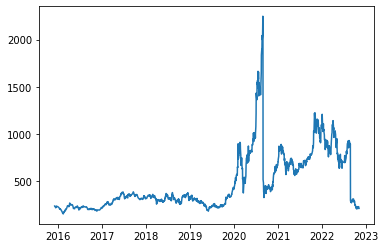

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['tweeted_at'], df['diff_after_1_day'])

# Convert dataset to LSTM layer compatible format

In [ ]:
import numpy as np

DATES_COLUMN = 0
FEATURE_START_INDEX = 8
LABLE_COLUMN = 2

def convert_dataframe_to_date_features_label(dataframe):
  df_as_np = dataframe.to_numpy()

  dates = df_as_np[:, DATES_COLUMN]

  middle_matrix = df_as_np[:, FEATURE_START_INDEX:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, LABLE_COLUMN]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, features_dataset, label_dataset = convert_dataframe_to_date_features_label(df)

dates.shape, features_dataset.shape, label_dataset.shape

((1524,), (1524, 9, 1), (1524,))

# Split the dataset into train, validation and test datasets

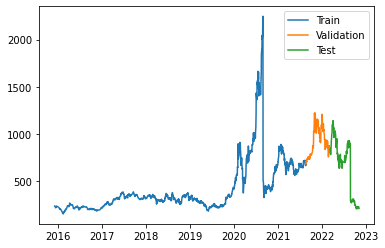

In [ ]:
TRAIN_DATA_START = 0.8
TRAIN_DATA_START_END = 0.9 

dataset_80 = int(len(dates) * TRAIN_DATA_START)
dataset_90 = int(len(dates) * TRAIN_DATA_START_END)

dates_train, X_train, y_train = dates[:dataset_80], features_dataset[:dataset_80], label_dataset[:dataset_80]

dates_val, X_val, y_val = dates[dataset_80:dataset_90], features_dataset[dataset_80:dataset_90], label_dataset[dataset_80:dataset_90]
dates_test, X_test, y_test = dates[dataset_90:], features_dataset[dataset_90:], label_dataset[dataset_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Compile the model and train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((9, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = model.fit(X_train,
          y_train,
          validation_data=(X_val, y_val),
          epochs=1000,
          verbose=0)

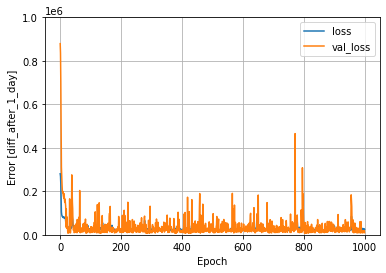

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [diff_after_1_day]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Evaluate the result to see the accuracy

In [ ]:
model.evaluate(X_val, y_val)

5/5 [==============================] - 0s 5ms/step - loss: 9929.4805 - mean_absolute_error: 72.8094


[9929.48046875, 72.80937194824219]

# Compare the predicted values to the training output

39/39 [==============================] - 1s 4ms/step


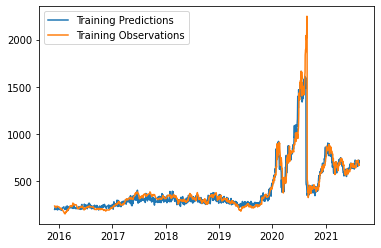

In [ ]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# Compare the predicted values to the validation output

5/5 [==============================] - 0s 5ms/step


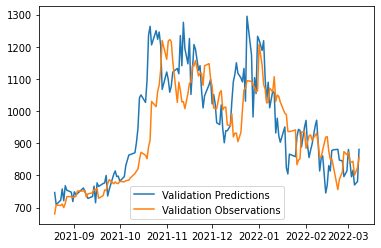

In [ ]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

# Compare the predicted values to the test output

5/5 [==============================] - 0s 5ms/step


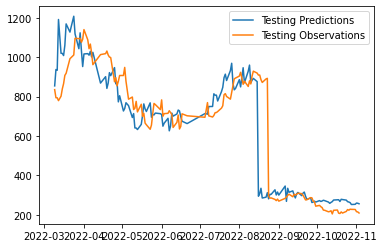

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Show them toghether

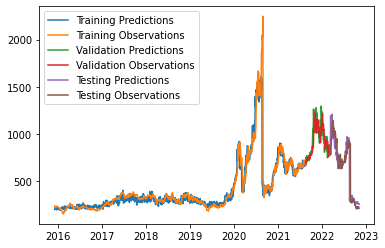

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Save the model locally

In [ ]:
import uuid

MODEL_VERSION = str(uuid.uuid4())[:8]
MODEL_NAME = 'TSLA_ELON_MUSK'

model.save(f'{MODEL_NAME}_{MODEL_VERSION}')

In [ ]:
import os

from google.cloud import storage


class CloudStorageUtils:

    def __init__(self):
        self.storage_client = storage.Client(project=os.getenv('GOOGLE_PROJECT_ID', 'attila-szombati-sandbox'))

    def save_data_to_cloud_storage(self, bucket_name: str, file_name: str, file: str):
        bucket = self.storage_client.get_bucket(bucket_name)
        blob = bucket.blob(file_name)
        blob.upload_from_filename(file)

    def set_fingerprint_for_user(self, bucket_name: str, file_name: str, fingerprint: str):
        bucket = self.storage_client.get_bucket(bucket_name)
        blob = bucket.blob(file_name)
        blob.upload_from_string(data=fingerprint)

    def get_fingerprint_for_user(self, bucket_name: str, file_name: str) -> str:
        bucket = self.storage_client.get_bucket(bucket_name)
        blob = bucket.blob(file_name)
        return blob.download_as_text()


# Deploy the model assets to Cloud Storage

In [ ]:
!pip install gcsfs
import gcsfs

PREDICTOR_BUCKET = 'stock_predictor_bucket'

gcs_storage = CloudStorageUtils()

gcs_storage.set_fingerprint_for_user(
            bucket_name=PREDICTOR_BUCKET,
            file_name='latest_version.csv',
            fingerprint=MODEL_VERSION
        )

fs = gcsfs.GCSFileSystem()

fs.put(f'{MODEL_NAME}_{MODEL_VERSION}', PREDICTOR_BUCKET, recursive=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[None, None, None, None]

In [ ]:
predictor_version = gcs_storage.get_fingerprint_for_user(bucket_name=PREDICTOR_BUCKET,
                                                             file_name='latest_version.csv')

# Load the model from GCS and test if it's working

In [ ]:
from tensorflow import keras

get_model_from_gcs = keras.models.load_model(f'gs://{PREDICTOR_BUCKET}/{MODEL_NAME}_{predictor_version}')

# Let's check:
np.testing.assert_allclose(
    model.predict(X_test), get_model_from_gcs.predict(X_test)
)

5/5 [==============================] - 1s 4ms/step
